**Introduction**

*   Online job portals
*   LinkedIn, Indeed, and Glassdoor
*   Fraudulent job postings and scams.
*   250% increase in job scams.

**Dataset**

Source - Employment Scam Aegean Dataset (EMSCAD). It is from University of the Aegean.

Number of rows - 17,880.

It consists of Fraudulent and legitamate job listings.

It has also mentioned disclaimer -  due human error in judgement during the annotation process, some entries might belong to the wrong class.


*   Legitimate - 17014
*   Fraudulent - 866

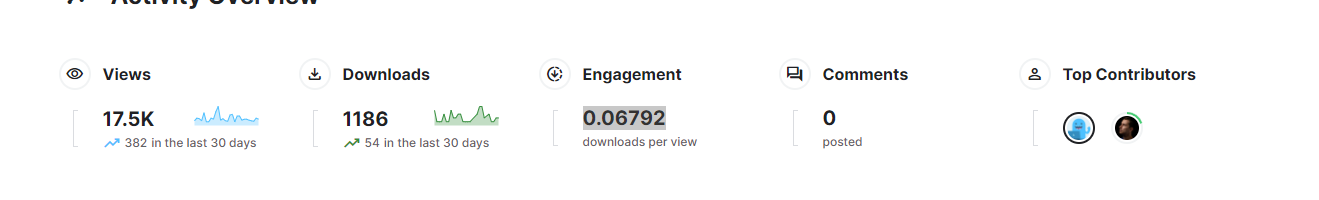

In [ ]:
!pip install beautifulsoup4

In [ ]:
import pandas as pd
import nltk
import string
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
file_path = '/content/drive/MyDrive/NLP/DataSet.csv'
file_path_local = '/content/DataSet.csv'
df = pd.read_csv(file_path)
df = df[['title', 'company_profile', 'description', 'has_company_logo', 'fraudulent']]
#df.head

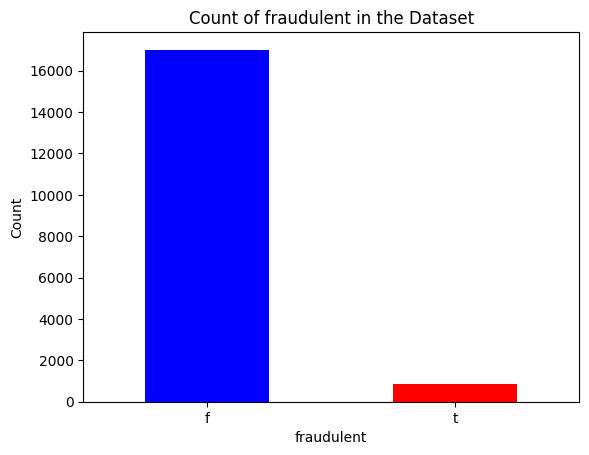

In [ ]:
column_name = 'fraudulent'

column_counts = df[column_name].value_counts()


column_counts.plot(kind='bar', rot=0, color=['blue', 'red'])


plt.xlabel(column_name)
plt.ylabel('Count')
plt.title(f'Count of {column_name} in the Dataset')


plt.show()

**Data Preprocessing:-**


**Columns Used**

*   Title - Job role
*   Company Profile - A brief company description.
*   Description - The details description of the job ad.
*   has Company logo - True if company logo is present.
*   Fraudulent - Classification attribute.



**Removing HTML tags in the dataset columns**


In [ ]:
# Removing HTML tags in the dataset columns
df['description'] = df['description'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())
df['company_profile'] = df['company_profile'].astype(str).apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())
df.head

<bound method NDFrame.head of                                                    title  \
0                                       Marketing Intern   
1              Customer Service - Cloud Video Production   
2                Commissioning Machinery Assistant (CMA)   
3                      Account Executive - Washington DC   
4                                    Bill Review Manager   
...                                                  ...   
17875                   Account Director - Distribution    
17876                                 Payroll Accountant   
17877  Project Cost Control Staff Engineer - Cost Con...   
17878                                   Graphic Designer   
17879                         Web Application Developers   

                                         company_profile  \
0      We're Food52, and we've created a groundbreaki...   
1      90 Seconds, the worlds Cloud Video Production ...   
2      \nValor Services provides Workforce Solutions ...   
3      Ou

In [ ]:
count = df['fraudulent'].value_counts()
print(count[0])
print(count[1])


In [ ]:
#separating labels for balancing dataset
x = df.iloc[:, :-1]
y = df.iloc[:, -1]

Balancing the dataset

In [ ]:
df['fraudulent'] = df['fraudulent'].map({'t': 1, 'f': 0})
df.head

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
count = df['fraudulent'].value_counts()
print(count[0])
print(count[1])


**Challenge with the dataset** : Dataset is imblanced.

To resolve this methods implemented:


*   Undersampling
*   Oversampling








**Undersampling**

In [ ]:
# import library
from collections import Counter
import imblearn
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42, replacement=True)

# fit predictor and target varialbe
x_rus, y_rus = rus.fit_resample(x, y)

df = pd.DataFrame(x_rus,columns=x.columns)
df['fraudulent'] = y_rus

print('original dataset shape:', Counter(y))
print('Resample dataset shape', Counter(y_rus))

original dataset shape: Counter({'f': 17014, 't': 866})
Resample dataset shape Counter({'f': 866, 't': 866})


Oversampling



In [ ]:
# import library
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

ros = RandomOverSampler(random_state=42)

# fit predictor and target varaible
x_ros, y_ros = ros.fit_resample(x, y)

df = pd.DataFrame(x_ros,columns=x.columns)
df['fraudulent'] = y_ros
print('Original dataset shape', Counter(y))
print('Resample dataset shape', Counter(y_ros))

Original dataset shape Counter({'f': 17014, 't': 866})
Resample dataset shape Counter({'f': 17014, 't': 17014})


**Challenges with balancing methods**

Weighted loss:


*   Implemented it, but couldn't apply it on this dataset
*   List item

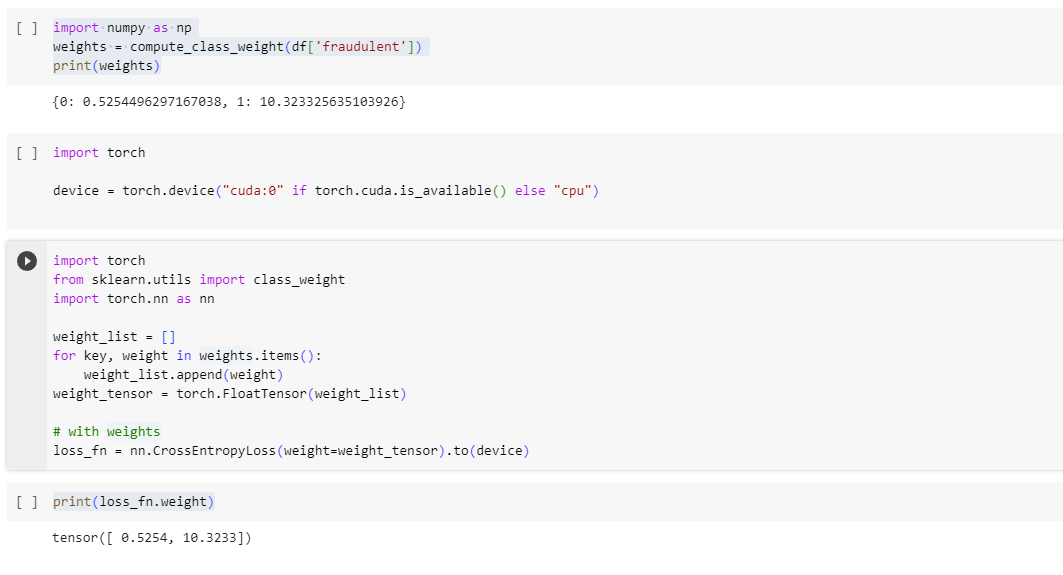




Weighted loss

In [ ]:

def compute_class_weight(train_y):
    """
    Compute class weight given imbalanced training data
    Usually used in the neural network model to augment the loss function (weighted loss function)
    Favouring/giving more weights to the rare classes.
    """
    import sklearn.utils.class_weight as scikit_class_weight

    class_list = list(set(train_y))
    class_weight_value = scikit_class_weight.compute_class_weight(class_weight ='balanced', classes = class_list, y = train_y)
    class_weight = dict()

    # Initialize all classes in the dictionary with weight 1
    curr_max = int(np.max(class_list))
    for i in range(curr_max):
        class_weight[i] = 1

    # Build the dictionary using the weight obtained the scikit function
    for i in range(len(class_list)):
        class_weight[class_list[i]] = class_weight_value[i]

    return class_weight

In [ ]:
import numpy as np
weights = compute_class_weight(df['fraudulent'])
print(weights)

In [ ]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
import torch
from sklearn.utils import class_weight
import torch.nn as nn

weight_list = []
for key, weight in weights.items():
    weight_list.append(weight)
weight_tensor = torch.FloatTensor(weight_list)

# with weights
loss_fn = nn.CrossEntropyLoss(weight=weight_tensor).to(device)

In [ ]:
print(loss_fn.weight)

In [ ]:
df.shape

(17880, 5)

**Feature Engineering**


*   Tokenize
*   Parts of speech
*   Counting the number of words
*   Combinations of Unigram,bigram and trigram



In [ ]:
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)

    # Convert tokens to lowercase
    tokens = [word.lower() for word in tokens]

    # Remove punctuation
    tokens = [word for word in tokens if word not in string.punctuation]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Join tokens back into a cleaned sentence
    cleaned_text = ' '.join(tokens)

    return cleaned_text

In [ ]:
# Tokenizing dataset columns
df['description'] = df['description'].apply(preprocess_text)
df['company_profile'] = df['company_profile'].apply(preprocess_text)
#df.head

In [ ]:
# Feature Engineering
# Num of words per review title
df['company_profile_num_words'] = df['company_profile'].apply(lambda x:len(x.split()))
df['description_num_words'] = df['description'].apply(lambda x:len(x.split()))

In [ ]:
# Get Parts of speech
def get_pos_counts(text):
  count_noun, count_verb, count_adj = 0, 0, 0
  words = word_tokenize(text)
  pos_tags = pos_tag(words)
  for word, tag in pos_tags:
    if tag.startswith('N'):
      count_noun += 1
    elif tag.startswith('V'):
      count_verb += 1
    elif tag.startswith('J'):
      count_adj += 1
  return count_noun, count_verb, count_adj

df[['company_profile_noun', 'company_profile_verb', 'company_profile_adj']] = df['company_profile'].apply(get_pos_counts).apply(pd.Series)
df[['description_noun', 'description_verb', 'description_adj']] = df['description'].apply(get_pos_counts).apply(pd.Series)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import scipy.sparse as sp
# Unigrams
def uni_features(data):
  vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1))
  sparse_matrix = vectorizer.fit_transform(data)
  return sparse_matrix.getnnz(axis=1)

# Bigrams
def bi_features(data):
  vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 2))
  sparse_matrix = vectorizer.fit_transform(data)
  return sparse_matrix.getnnz(axis=1)

# Trigrams
def tri_features(data):
  vectorizer = CountVectorizer(analyzer='word', ngram_range=(3, 3))
  sparse_matrix = vectorizer.fit_transform(data)
  return sparse_matrix.getnnz(axis=1)

In [ ]:
# Unigrams and Bigrams
def uni_bi_features(data):
  vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 2))
  sparse_matrix = vectorizer.fit_transform(data)
  return sparse_matrix.getnnz(axis=1)

# Bigrams and Trigrams
def bi_tri_features(data):
  vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 3))
  sparse_matrix = vectorizer.fit_transform(data)
  return sparse_matrix.getnnz(axis=1)

# Unigrams, Bigrams and trigrams
def uni_bi_tri_features(data):
  vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 3))
  sparse_matrix = vectorizer.fit_transform(data)
  return sparse_matrix.getnnz(axis=1)

In [ ]:
df['company_profile_unigram'] = uni_features(df['company_profile'])
df['company_profile_bigram'] = bi_features(df['company_profile'])
df['company_profile_trigram'] = tri_features(df['company_profile'])
df['company_profile_uni_and_bi'] = uni_bi_features(df['company_profile'])
df['company_profile_bi_and_tri'] = bi_tri_features(df['company_profile'])
df['company_profile_uini_bi_tri'] = uni_bi_tri_features(df['company_profile'])

In [ ]:
df['description_unigram'] = uni_features(df['description'])
df['description_bigram'] = bi_features(df['description'])
df['description_trigram'] = tri_features(df['description'])
df['description_uni_and_bi'] = uni_bi_features(df['description'])
df['description_bi_and_tri'] = bi_tri_features(df['description'])
df['description_uini_bi_tri'] = uni_bi_tri_features(df['description'])

In [ ]:
#converting values to int
df['has_company_logo'] = df['has_company_logo'].map({'t': 1, 'f': 0})
df['fraudulent'] = df['fraudulent'].map({'t': 1, 'f': 0})

In [ ]:
y = df['fraudulent']
df.drop('fraudulent', axis=1, inplace=True)
x = df

# Naive Bayes Model

**Features used to evaluate Naive Bayes Model**

*   Number of words from description
*   Number of words company profile
*   Combination of bigram and trigram for company profile
*   Combination of bigram and trigram for description










In [ ]:
#Splitting test and train data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

Naive Bayes Without OverSampling on Raw dataset

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from scipy.sparse import hstack
from scipy.sparse import hstack, csr_matrix

# Combine the text data for fitting the vectorizer
combined_text_train = x_train['title'] + " " + x_train['company_profile'] + " " + x_train['description']
combined_text_test = x_test['title'] + " " + x_test['company_profile'] + " " + x_test['description']

# Initialize a single vectorizer for both train and test data
vectorizer = TfidfVectorizer()

# Fit and transform on the combined training text
X_train_transformed = vectorizer.fit_transform(combined_text_train)

# Only transform the test data using the vocabulary learned from the training data
X_test_transformed = vectorizer.transform(combined_text_test)

train_description_reshaped = x_train['description_num_words'].values.reshape(-1,1)
test_description_reshaped = x_test['description_num_words'].values.reshape(-1,1)

train_logo_reshaped = x_train['description_num_words'].values.reshape(-1,1)
test_logo_reshaped = x_test['description_num_words'].values.reshape(-1,1)

train_unigram_description = x_train['description_bi_and_tri'].values.reshape(-1,1)
test_unigram_description = x_test['description_bi_and_tri'].values.reshape(-1,1)

train_unigram_company_profile = x_train['company_profile_bi_and_tri'].values.reshape(-1,1)
test_unigram_company_profile = x_test['company_profile_bi_and_tri'].values.reshape(-1,1)

X_train_1 = hstack([X_train_transformed, x_train['company_profile_num_words'].values.reshape(-1,1),
                    train_description_reshaped,train_logo_reshaped,train_unigram_description,train_unigram_company_profile])
X_test_1 = hstack([X_test_transformed, x_test['company_profile_num_words'].values.reshape(-1,1),
                   test_description_reshaped,test_logo_reshaped,test_unigram_description,test_unigram_company_profile])

# Train your model using the transformed data
model_NB = MultinomialNB()
model_NB.fit(X_train_1, y_train)

# Predict using the test data
y_pred_NB = model_NB.predict(X_test_1)

# Evaluate the model's performance
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_NB))
print(report)


Confusion Matrix:
[[2707  688]
 [  44  137]]
              precision    recall  f1-score   support

           0       0.98      0.80      0.88      3395
           1       0.17      0.76      0.27       181

    accuracy                           0.80      3576
   macro avg       0.58      0.78      0.58      3576
weighted avg       0.94      0.80      0.85      3576



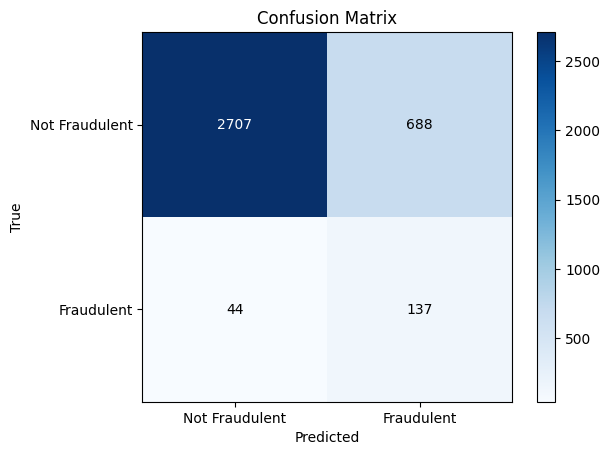

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix


conf_matrix = np.array([[2707, 688], [44, 137]])

#  function to plot the confusion matrix with colors
def plot_confusion_matrix(cm, cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()

    # Add text annotations
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(np.arange(len(cm)), ['Not Fraudulent', 'Fraudulent'])
    plt.yticks(np.arange(len(cm)), ['Not Fraudulent', 'Fraudulent'])

    # Add numerical values within the cells
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

# Display the confusion matrix
plot_confusion_matrix(conf_matrix)
plt.show()


Undersampling - Naive Bayes

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from scipy.sparse import hstack
from scipy.sparse import hstack, csr_matrix
from sklearn.metrics import confusion_matrix

# Combine the text data for fitting the vectorizer
combined_text_train = x_train['title'] + " " + x_train['company_profile'] + " " + x_train['description']
combined_text_test = x_test['title'] + " " + x_test['company_profile'] + " " + x_test['description']

# Initialize a single vectorizer for both train and test data
vectorizer = TfidfVectorizer()

# Fit and transform on the combined training text
X_train_transformed = vectorizer.fit_transform(combined_text_train)

# Only transform the test data using the vocabulary learned from the training data
X_test_transformed = vectorizer.transform(combined_text_test)

train_description_reshaped = x_train['description_num_words'].values.reshape(-1,1)
test_description_reshaped = x_test['description_num_words'].values.reshape(-1,1)

train_logo_reshaped = x_train['description_num_words'].values.reshape(-1,1)
test_logo_reshaped = x_test['description_num_words'].values.reshape(-1,1)

train_unigram_description = x_train['description_bi_and_tri'].values.reshape(-1,1)
test_unigram_description = x_test['description_bi_and_tri'].values.reshape(-1,1)

train_unigram_company_profile = x_train['company_profile_bi_and_tri'].values.reshape(-1,1)
test_unigram_company_profile = x_test['company_profile_bi_and_tri'].values.reshape(-1,1)

X_train_1 = hstack([X_train_transformed, x_train['company_profile_num_words'].values.reshape(-1,1),
                    train_description_reshaped,train_logo_reshaped,train_unigram_description,train_unigram_company_profile])
X_test_1 = hstack([X_test_transformed, x_test['company_profile_num_words'].values.reshape(-1,1),
                   test_description_reshaped,test_logo_reshaped,test_unigram_description,test_unigram_company_profile])

# Train your model using the transformed data
model_NB = MultinomialNB()
model_NB.fit(X_train_1, y_train)

# Predict using the test data
y_pred_NB = model_NB.predict(X_test_1)

# Evaluate the model's performance
report = classification_report(y_test, y_pred_NB, zero_division=1)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_NB))
print(report)

Confusion Matrix:
[[121  61]
 [ 44 121]]
              precision    recall  f1-score   support

           0       0.73      0.66      0.70       182
           1       0.66      0.73      0.70       165

    accuracy                           0.70       347
   macro avg       0.70      0.70      0.70       347
weighted avg       0.70      0.70      0.70       347



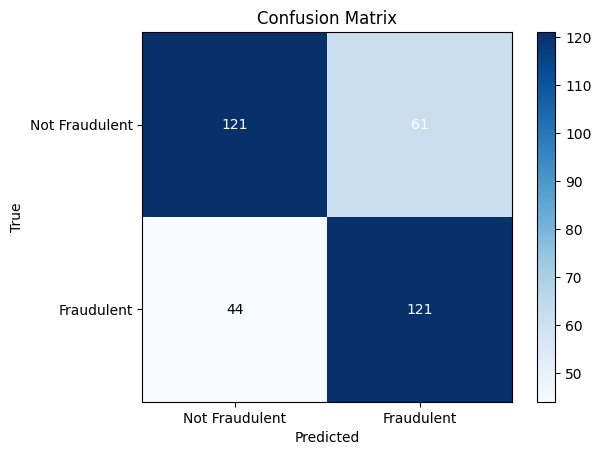

In [ ]:
conf_matrix = np.array([[121, 61], [44, 121]])

# Display the confusion matrix
plot_confusion_matrix(conf_matrix)
plt.show()


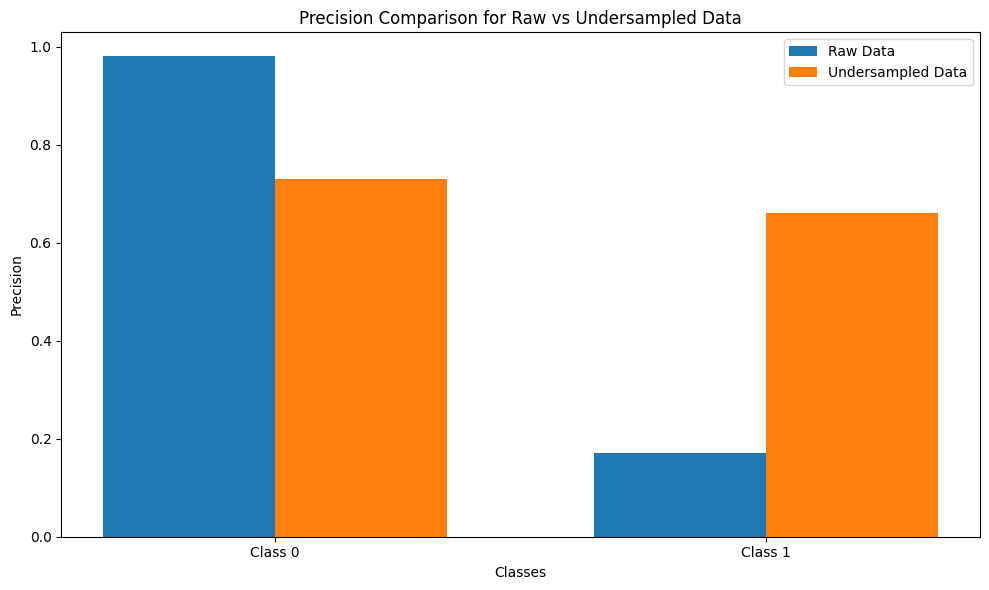

In [ ]:
import matplotlib.pyplot as plt

raw_precision_0 = 0.98
raw_recall_0 = 0.80
raw_precision_1 = 0.17
raw_recall_1 = 0.76

undersampled_precision_0 = 0.73
undersampled_recall_0 = 0.66
undersampled_precision_1 = 0.66
undersampled_recall_1 = 0.73

# Creating lists for precision and recall values
raw_precision = [raw_precision_0, raw_precision_1]
raw_recall = [raw_recall_0, raw_recall_1]
undersampled_precision = [undersampled_precision_0, undersampled_precision_1]
undersampled_recall = [undersampled_recall_0, undersampled_recall_1]

# Setting up the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = range(2)

# Plotting bars for precision
bar1 = ax.bar(index, raw_precision, bar_width, label='Raw Data')
bar2 = ax.bar([i + bar_width for i in index], undersampled_precision, bar_width, label='Undersampled Data')

# Adding labels, title, and legend
ax.set_xlabel('Classes')
ax.set_ylabel('Precision')
ax.set_title('Precision Comparison for Raw vs Undersampled Data')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(['Class 0', 'Class 1'])
ax.legend()

# Showing the plot
plt.tight_layout()
plt.show()




Naive Bayes on Oversampling

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from scipy.sparse import hstack
from scipy.sparse import hstack, csr_matrix
from sklearn.metrics import confusion_matrix

# Combine the text data for fitting the vectorizer
combined_text_train = x_train['title'] + " " + x_train['company_profile'] + " " + x_train['description']
combined_text_test = x_test['title'] + " " + x_test['company_profile'] + " " + x_test['description']

# Initialize a single vectorizer for both train and test data
vectorizer = TfidfVectorizer()

# Fit and transform on the combined training text
X_train_transformed = vectorizer.fit_transform(combined_text_train)

# Only transform the test data using the vocabulary learned from the training data
X_test_transformed = vectorizer.transform(combined_text_test)

train_description_reshaped = x_train['description_num_words'].values.reshape(-1,1)
test_description_reshaped = x_test['description_num_words'].values.reshape(-1,1)

train_logo_reshaped = x_train['description_num_words'].values.reshape(-1,1)
test_logo_reshaped = x_test['description_num_words'].values.reshape(-1,1)

train_unigram_description = x_train['description_bi_and_tri'].values.reshape(-1,1)
test_unigram_description = x_test['description_bi_and_tri'].values.reshape(-1,1)

train_unigram_company_profile = x_train['company_profile_bi_and_tri'].values.reshape(-1,1)
test_unigram_company_profile = x_test['company_profile_bi_and_tri'].values.reshape(-1,1)

X_train_1 = hstack([X_train_transformed, x_train['company_profile_num_words'].values.reshape(-1,1),
                    train_description_reshaped,train_logo_reshaped,train_unigram_description,train_unigram_company_profile])
X_test_1 = hstack([X_test_transformed, x_test['company_profile_num_words'].values.reshape(-1,1),
                   test_description_reshaped,test_logo_reshaped,test_unigram_description,test_unigram_company_profile])

# Train your model using the transformed data
model_NB = MultinomialNB()
model_NB.fit(X_train_1, y_train)

# Predict using the test data
y_pred_NB = model_NB.predict(X_test_1)

# Evaluate the model's performance
report = classification_report(y_test, y_pred_NB, zero_division=1)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_NB))
print(report)


Confusion Matrix:
[[2280 1116]
 [ 747 2663]]
              precision    recall  f1-score   support

           0       0.75      0.67      0.71      3396
           1       0.70      0.78      0.74      3410

    accuracy                           0.73      6806
   macro avg       0.73      0.73      0.73      6806
weighted avg       0.73      0.73      0.73      6806



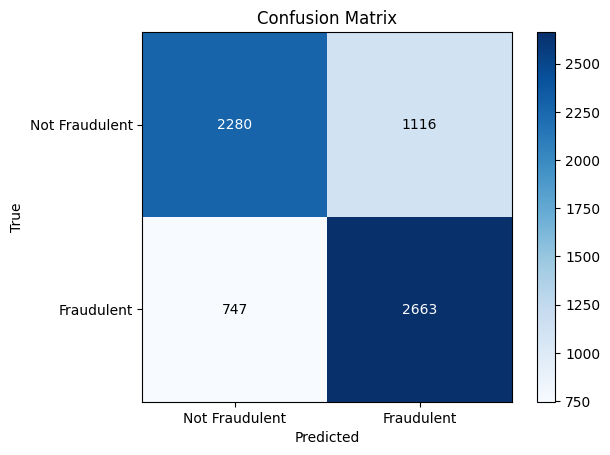

In [ ]:
conf_matrix = np.array([[2280, 1116], [747, 2663]])

# Display the confusion matrix
plot_confusion_matrix(conf_matrix)
plt.show()


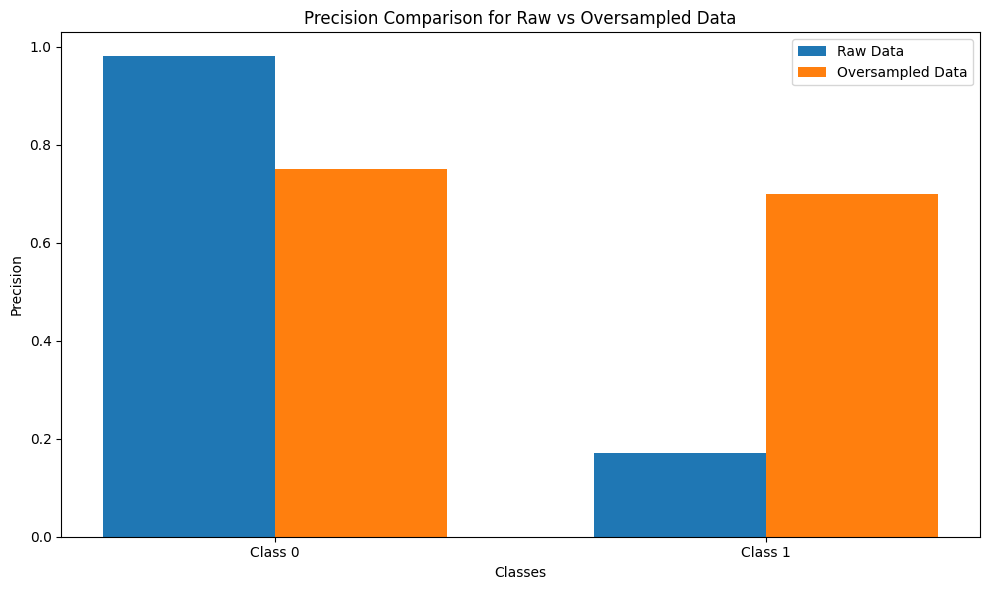

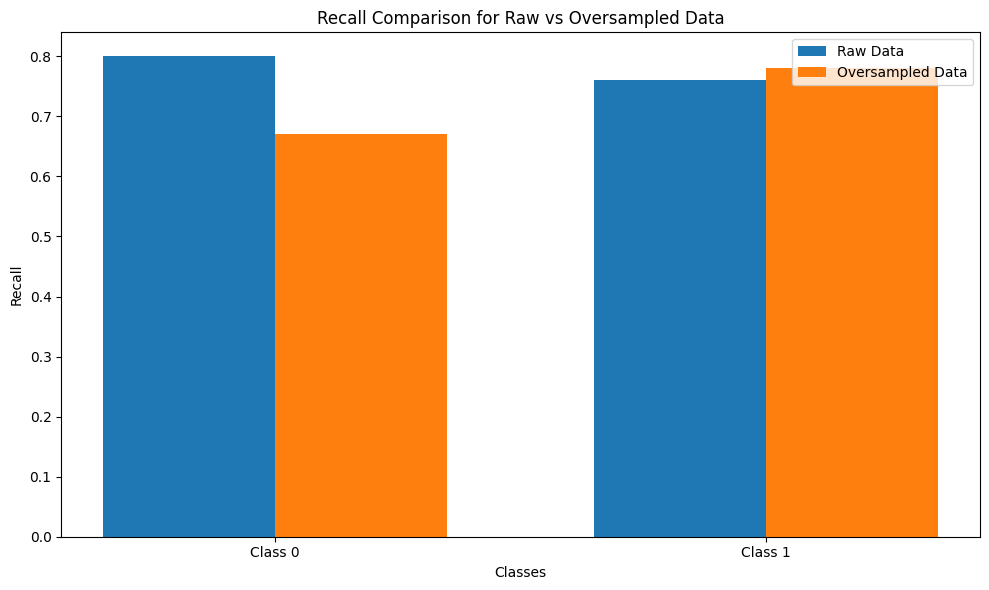

In [ ]:
import matplotlib.pyplot as plt

# Precision and recall values for raw data
raw_precision_0 = 0.98
raw_recall_0 = 0.80
raw_precision_1 = 0.17
raw_recall_1 = 0.76

# Precision and recall values for oversampled data
oversampled_precision_0 = 0.75
oversampled_recall_0 = 0.67
oversampled_precision_1 = 0.70
oversampled_recall_1 = 0.78

# Creating lists for precision and recall values
raw_precision = [raw_precision_0, raw_precision_1]
raw_recall = [raw_recall_0, raw_recall_1]
oversampled_precision = [oversampled_precision_0, oversampled_precision_1]
oversampled_recall = [oversampled_recall_0, oversampled_recall_1]

# Setting up the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = range(2)

# Plotting bars for precision
bar1 = ax.bar(index, raw_precision, bar_width, label='Raw Data')
bar2 = ax.bar([i + bar_width for i in index], oversampled_precision, bar_width, label='Oversampled Data')

# Adding labels, title, and legend for precision comparison
ax.set_xlabel('Classes')
ax.set_ylabel('Precision')
ax.set_title('Precision Comparison for Raw vs Oversampled Data')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(['Class 0', 'Class 1'])
ax.legend()

# Showing the precision plot
plt.tight_layout()
plt.show()

# Plotting recall
fig, ax = plt.subplots(figsize=(10, 6))

bar1 = ax.bar(index, raw_recall, bar_width, label='Raw Data')
bar2 = ax.bar([i + bar_width for i in index], oversampled_recall, bar_width, label='Oversampled Data')

ax.set_xlabel('Classes')
ax.set_ylabel('Recall')
ax.set_title('Recall Comparison for Raw vs Oversampled Data')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(['Class 0', 'Class 1'])
ax.legend()

plt.tight_layout()
plt.show()


**Evaluation:**

**Accuracy:** The raw data model has higher accuracy 0.80 compared to the oversampled data model 0.73.

**Precision:** The raw data model has higher precision for class 0 0.98 but lower precision for class 1 0.17 compared to the oversampled data model with balanced precision for both classes 0.75 and 0.70.

**Recall:** The oversampled data model has higher recall for both classes 0.67 and 0.78 compared to the raw data model 0.80 and 0.76.

**F1-score:** The F1-scores for both classes are generally higher in the oversampled data model than in the raw data model.

**Conclusion:**
The raw data model performs better in terms of accuracy and precision for class 0, but it lacks in recall and precision for class 1.
The oversampled data model has balanced precision for both classes and better recall rates for both classes, but it sacrifices some accuracy compared to the raw data model.
If equal importance is placed on both classes and higher recall is desired, the oversampled data model might be preferable despite its slightly lower accuracy.

**Pre Trained model**

Steps:


1.   Split dataset into train and test
2.   Concatenating train data and test data with labels
3.   Converting it into dataset using pandas library
4.   Tokenizing the data using padding and truncation
5.   Training the model and calculating the accuracy.



**Pre trained model on Raw Data**

In [ ]:
y = df['fraudulent']
df.drop('fraudulent', axis=1, inplace=True)
x = df

In [ ]:
y= y.map({'t': 1, 'f': 0})
print(y)

0        0
1        0
2        0
3        0
4        0
        ..
17875    0
17876    0
17877    0
17878    0
17879    0
Name: fraudulent, Length: 17880, dtype: int64


In [ ]:
x=x[['company_profile','description']]
print(x)

                                         company_profile  \
0      We're Food52, and we've created a groundbreaki...   
1      90 Seconds, the worlds Cloud Video Production ...   
2      \nValor Services provides Workforce Solutions ...   
3      Our passion for improving quality of life thro...   
4      SpotSource Solutions LLC is a Global Human Cap...   
...                                                  ...   
17875  Vend is looking for some awesome new talent to...   
17876  WebLinc is the e-commerce platform and service...   
17877  We Provide Full Time Permanent Positions for m...   
17878                                                nan   
17879  Vend is looking for some awesome new talent to...   

                                             description  
0      Food52, a fast-growing, James Beard Award-winn...  
1      Organised - Focused - Vibrant - Awesome!Do you...  
2      Our client, located in Houston, is actively se...  
3      THE COMPANY: ESRI – Environmental Sy

In [ ]:
import numpy as np
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [ ]:
x_train = pd.concat([x_train, y_train], axis=1)
x_test = pd.concat([x_test, y_test], axis=1)

In [ ]:
!pip install transformers
!pip install datasets
!pip install transformers[torch]
!pip install accelerate -U

In [ ]:
import datasets
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import confusion_matrix

In [ ]:
from datasets import Dataset, load_metric
train_dataset = Dataset.from_pandas(x_train)
test_dataset = Dataset.from_pandas(x_test)
print(train_dataset)
print(test_dataset)

Dataset({
    features: ['company_profile', 'description', 'fraudulent', '__index_level_0__'],
    num_rows: 14304
})
Dataset({
    features: ['company_profile', 'description', 'fraudulent', '__index_level_0__'],
    num_rows: 3576
})


In [ ]:
from transformers import AutoModelForSequenceClassification, BertForSequenceClassification
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = (AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to(device))

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# Tokenization function
def tokenize_function(examples):
  return tokenizer(examples['company_profile'], truncation=True, padding=True)

In [ ]:
train_tokenized_datasets = train_dataset.map(tokenize_function, batched=True)
test_tokenized_datasets = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/14304 [00:00<?, ? examples/s]

Map:   0%|          | 0/3576 [00:00<?, ? examples/s]

In [ ]:
train_tokenized_datasets = train_tokenized_datasets.rename_column("fraudulent","labels")
train_tokenized_datasets = train_tokenized_datasets.with_format("torch")

In [ ]:
test_tokenized_datasets = test_tokenized_datasets.rename_column("fraudulent","labels")
test_tokenized_datasets = test_tokenized_datasets.with_format("torch")

In [ ]:
metric = load_metric("accuracy")

<ipython-input-23-21f3ecd7ee32>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [ ]:
def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  return metric.compute(predictions=predictions, references=labels)

In [ ]:
training_args = TrainingArguments(
"bert-trainer",
evaluation_strategy="epoch",
)

In [ ]:
trainer = Trainer(
model=model,
args=training_args,
train_dataset=train_tokenized_datasets,
eval_dataset=test_tokenized_datasets,
tokenizer=tokenizer,
compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.130900,0.121730,0.963367
2,0.107600,0.109486,0.963647
3,0.106600,0.114544,0.963926


TrainOutput(global_step=5364, training_loss=0.12222632536863232, metrics={'train_runtime': 4444.6188, 'train_samples_per_second': 9.655, 'train_steps_per_second': 1.207, 'total_flos': 1.129062160760832e+16, 'train_loss': 0.12222632536863232, 'epoch': 3.0})

In [ ]:
model_path = "/content/bert-trainer/checkpoint-4500"
bert_model = AutoModelForSequenceClassification.from_pretrained(model_path,num_labels=2)
bert_test_trainer = Trainer(bert_model)
raw_pred, _, _ = bert_test_trainer.predict(test_tokenized_datasets)
y_pred_lables = np.argmax(raw_pred, axis=1)
y_true_labels = y_test
print(classification_report(y_pred_lables,y_true_labels))
print(classification_report(y_pred_lables,y_true_labels))
print("Confusion Matrix:")
print(confusion_matrix(y_pred_lables, y_true_labels))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      3522
           1       0.29      0.96      0.44        54

    accuracy                           0.96      3576
   macro avg       0.64      0.96      0.71      3576
weighted avg       0.99      0.96      0.97      3576

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      3522
           1       0.29      0.96      0.44        54

    accuracy                           0.96      3576
   macro avg       0.64      0.96      0.71      3576
weighted avg       0.99      0.96      0.97      3576

Confusion Matrix:
[[3393  129]
 [   2   52]]


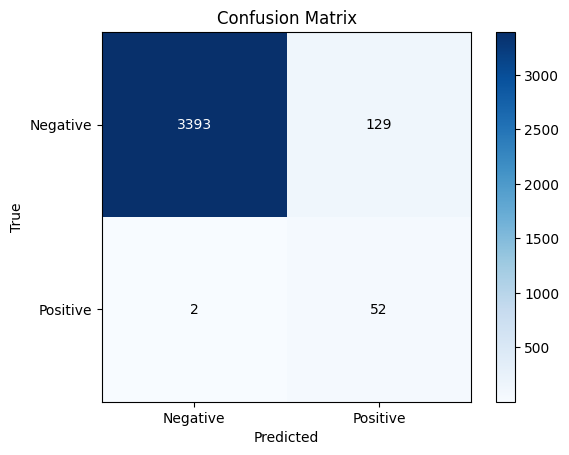

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Example confusion matrix
conf_matrix = np.array([[3393, 129], [2, 52]])

# Define a function to plot the confusion matrix with colors
def plot_confusion_matrix(cm, cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()

    # Add text annotations
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(np.arange(len(cm)), ['Negative', 'Positive'])
    plt.yticks(np.arange(len(cm)), ['Negative', 'Positive'])

    # Add numerical values within the cells
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

# Display the confusion matrix
plot_confusion_matrix(conf_matrix)
plt.show()


**PLM with Oversampling dataset**

In [ ]:
y = df['fraudulent']
df.drop('fraudulent', axis=1, inplace=True)
x = df


In [ ]:
y= y.map({'t': 1, 'f': 0})
print(y)

In [ ]:
print(y)
x=x[['company_profile','description']]
print(x)

In [ ]:
import numpy as np
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
x_train = pd.concat([x_train, y_train], axis=1)
x_test = pd.concat([x_test, y_test], axis=1)

In [ ]:
from datasets import Dataset, load_metric
train_dataset = Dataset.from_pandas(x_train)
test_dataset = Dataset.from_pandas(x_test)
print(train_dataset)
print(test_dataset)

Dataset({
    features: ['company_profile', 'description', 'fraudulent', '__index_level_0__'],
    num_rows: 27222
})
Dataset({
    features: ['company_profile', 'description', 'fraudulent', '__index_level_0__'],
    num_rows: 6806
})


In [ ]:
from transformers import AutoModelForSequenceClassification, BertForSequenceClassification
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = (AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to(device))

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, AutoTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# Tokenization function
def tokenize_function(examples):
  return tokenizer(examples['company_profile'], truncation=True, padding=True)

In [ ]:
train_tokenized_datasets = train_dataset.map(tokenize_function, batched=True)
test_tokenized_datasets = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/27222 [00:00<?, ? examples/s]

Map:   0%|          | 0/6806 [00:00<?, ? examples/s]

In [ ]:

train_tokenized_datasets = train_tokenized_datasets.rename_column("fraudulent","labels")

train_tokenized_datasets = train_tokenized_datasets.with_format("torch")

In [ ]:
test_tokenized_datasets = test_tokenized_datasets.rename_column("fraudulent","labels")
test_tokenized_datasets = test_tokenized_datasets.with_format("torch")

In [ ]:
metric = load_metric("accuracy")

<ipython-input-27-21f3ecd7ee32>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [ ]:
def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  return metric.compute(predictions=predictions, references=labels)

In [ ]:
training_args = TrainingArguments(
"bert-trainer",
evaluation_strategy="epoch",
)

In [ ]:
trainer = Trainer(
model=model,
args=training_args,
train_dataset=train_tokenized_datasets,
eval_dataset=test_tokenized_datasets,
tokenizer=tokenizer,
compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.236700,0.221978,0.917867
2,0.226000,0.212593,0.917867
3,0.208200,0.224834,0.917867


TrainOutput(global_step=10209, training_loss=0.23045704845630616, metrics={'train_runtime': 8550.9727, 'train_samples_per_second': 9.55, 'train_steps_per_second': 1.194, 'total_flos': 2.148722744702976e+16, 'train_loss': 0.23045704845630616, 'epoch': 3.0})

In [ ]:
model_path = "/content/bert-trainer/checkpoint-10000"
bert_model = AutoModelForSequenceClassification.from_pretrained(model_path,num_labels=2)
bert_test_trainer = Trainer(bert_model)
raw_pred, _, _ = bert_test_trainer.predict(test_tokenized_datasets)
y_pred_lables = np.argmax(raw_pred, axis=1)
y_true_labels = y_test
print(classification_report(y_pred_lables,y_true_labels))
print("Confusion Matrix:")
print(confusion_matrix(y_pred_lables, y_true_labels))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91      2837
           1       1.00      0.86      0.92      3969

    accuracy                           0.92      6806
   macro avg       0.92      0.93      0.92      6806
weighted avg       0.93      0.92      0.92      6806

Confusion Matrix:
[[2837    0]
 [ 559 3410]]


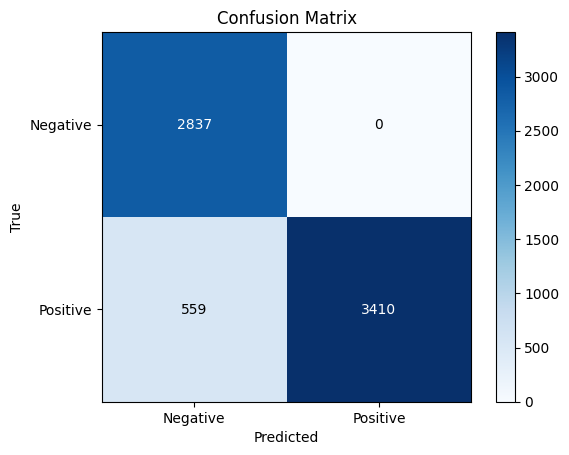

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Example confusion matrix
conf_matrix = np.array([[2837, 0], [559, 3410]])

# Define a function to plot the confusion matrix with colors
def plot_confusion_matrix(cm, cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()

    # Add text annotations
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(np.arange(len(cm)), ['Negative', 'Positive'])
    plt.yticks(np.arange(len(cm)), ['Negative', 'Positive'])

    # Add numerical values within the cells
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

# Display the confusion matrix
plot_confusion_matrix(conf_matrix)
plt.show()


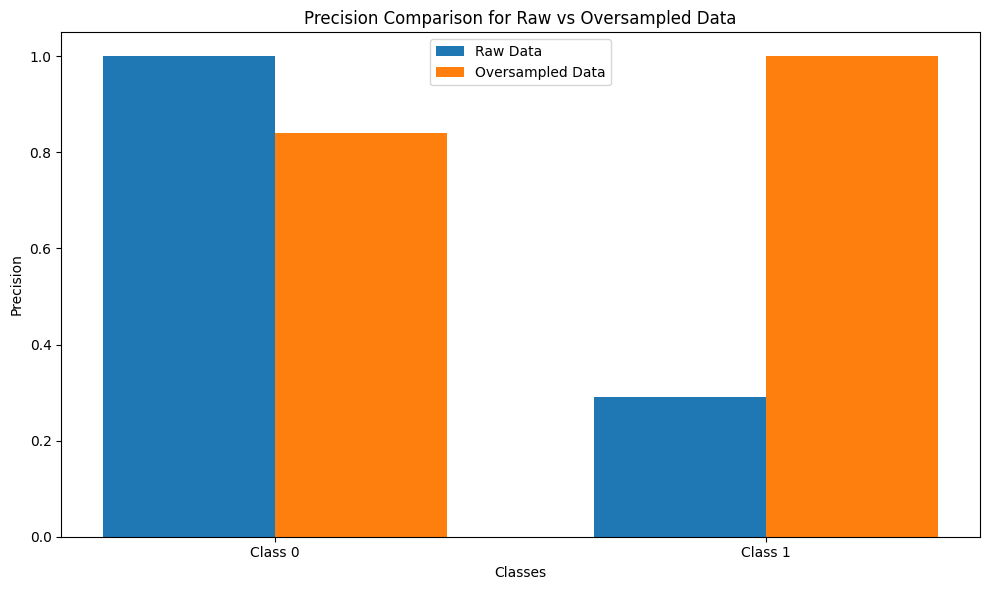

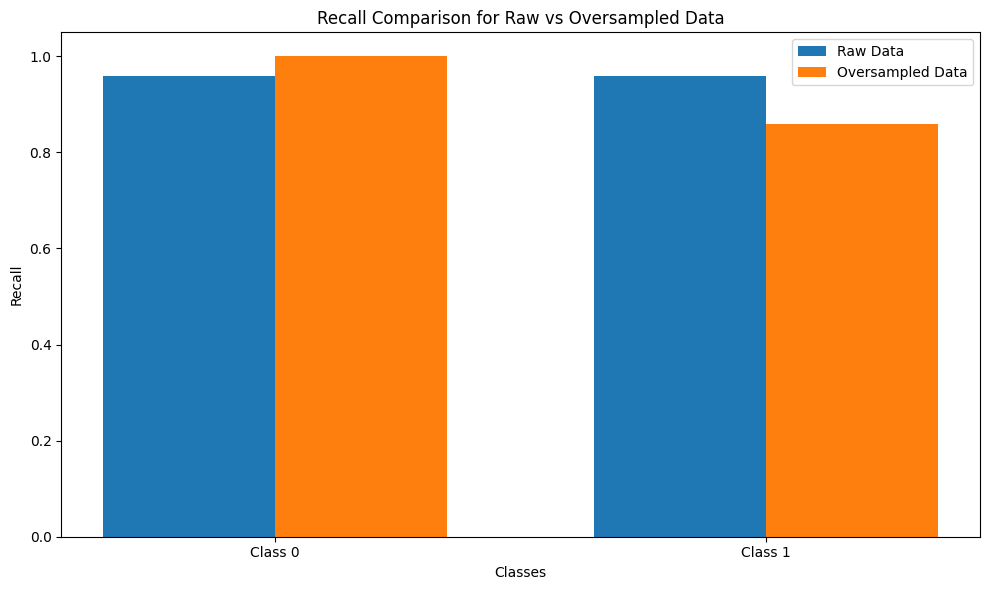

In [ ]:
import matplotlib.pyplot as plt

# Precision and recall values for raw data
raw_precision_0 = 1.00
raw_recall_0 = 0.96
raw_precision_1 = 0.29
raw_recall_1 = 0.96

# Precision and recall values for oversampled data
oversampled_precision_0 = 0.84
oversampled_recall_0 = 1.00
oversampled_precision_1 = 1.00
oversampled_recall_1 = 0.86

# Creating lists for precision and recall values
raw_precision = [raw_precision_0, raw_precision_1]
raw_recall = [raw_recall_0, raw_recall_1]
oversampled_precision = [oversampled_precision_0, oversampled_precision_1]
oversampled_recall = [oversampled_recall_0, oversampled_recall_1]

# Setting up the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = range(2)

# Plotting bars for precision
bar1 = ax.bar(index, raw_precision, bar_width, label='Raw Data')
bar2 = ax.bar([i + bar_width for i in index], oversampled_precision, bar_width, label='Oversampled Data')

# Adding labels, title, and legend for precision comparison
ax.set_xlabel('Classes')
ax.set_ylabel('Precision')
ax.set_title('Precision Comparison for Raw vs Oversampled Data')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(['Class 0', 'Class 1'])
ax.legend()

# Showing the precision plot
plt.tight_layout()
plt.show()

# Repeating the same process for recall values
fig, ax = plt.subplots(figsize=(10, 6))

bar1 = ax.bar(index, raw_recall, bar_width, label='Raw Data')
bar2 = ax.bar([i + bar_width for i in index], oversampled_recall, bar_width, label='Oversampled Data')

ax.set_xlabel('Classes')
ax.set_ylabel('Recall')
ax.set_title('Recall Comparison for Raw vs Oversampled Data')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(['Class 0', 'Class 1'])
ax.legend()

plt.tight_layout()
plt.show()


**PLM undersmapling dataset**

In [ ]:
y = df['fraudulent']
df.drop('fraudulent', axis=1, inplace=True)
x = df

In [ ]:
y= y.map({'t': 1, 'f': 0})
print(y)

In [ ]:
print(y)
x=x[['company_profile','description']]
print(x)

In [ ]:
import numpy as np
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
x_train = pd.concat([x_train, y_train], axis=1)
x_test = pd.concat([x_test, y_test], axis=1)

In [ ]:
from datasets import Dataset, load_metric
train_dataset = Dataset.from_pandas(x_train)
test_dataset = Dataset.from_pandas(x_test)
print(train_dataset)
print(test_dataset)

Dataset({
    features: ['company_profile', 'description', 'fraudulent', '__index_level_0__'],
    num_rows: 1385
})
Dataset({
    features: ['company_profile', 'description', 'fraudulent', '__index_level_0__'],
    num_rows: 347
})


In [ ]:
from transformers import AutoModelForSequenceClassification, BertForSequenceClassification
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = (AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to(device))

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, AutoTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# Tokenization function
def tokenize_function(examples):
  return tokenizer(examples['company_profile'], truncation=True, padding=True)

In [ ]:
train_tokenized_datasets = train_dataset.map(tokenize_function, batched=True)
test_tokenized_datasets = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/1385 [00:00<?, ? examples/s]

Map:   0%|          | 0/347 [00:00<?, ? examples/s]

In [ ]:
train_tokenized_datasets = train_tokenized_datasets.rename_column("fraudulent","labels")

train_tokenized_datasets = train_tokenized_datasets.with_format("torch")

In [ ]:
test_tokenized_datasets = test_tokenized_datasets.rename_column("fraudulent","labels")
test_tokenized_datasets = test_tokenized_datasets.with_format("torch")

In [ ]:
metric = load_metric("accuracy")

<ipython-input-29-21f3ecd7ee32>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [ ]:
def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  return metric.compute(predictions=predictions, references=labels)

In [ ]:
training_args = TrainingArguments(
"bert-trainer",
evaluation_strategy="epoch",
)

In [ ]:
trainer = Trainer(
model=model,
args=training_args,
train_dataset=train_tokenized_datasets,
eval_dataset=test_tokenized_datasets,
tokenizer=tokenizer,
compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.245623,0.913545
2,No log,0.240053,0.922190
3,0.287400,0.241987,0.922190


TrainOutput(global_step=522, training_loss=0.28257138199276394, metrics={'train_runtime': 435.4439, 'train_samples_per_second': 9.542, 'train_steps_per_second': 1.199, 'total_flos': 1093226435020800.0, 'train_loss': 0.28257138199276394, 'epoch': 3.0})

In [ ]:
model_path = "/content/bert-trainer/checkpoint-500"
bert_model = AutoModelForSequenceClassification.from_pretrained(model_path,num_labels=2)
bert_test_trainer = Trainer(bert_model)
raw_pred, _, _ = bert_test_trainer.predict(test_tokenized_datasets)
y_pred_lables = np.argmax(raw_pred, axis=1)
y_true_labels = y_test
print(classification_report(y_pred_lables,y_true_labels))
print("Confusion Matrix:")
print(confusion_matrix(y_pred_lables, y_true_labels))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       157
           1       0.99      0.86      0.92       190

    accuracy                           0.92       347
   macro avg       0.93      0.93      0.92       347
weighted avg       0.93      0.92      0.92       347

Confusion Matrix:
[[156   1]
 [ 26 164]]


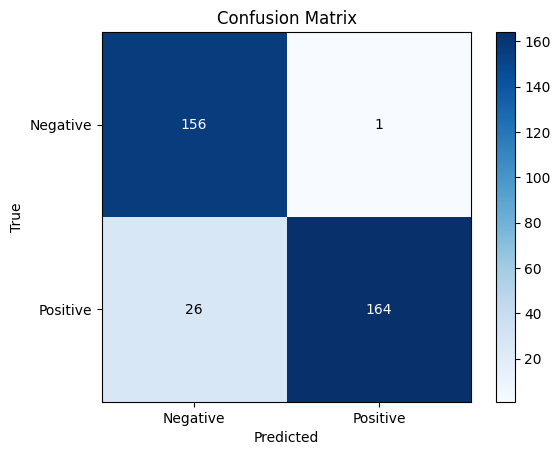

In [ ]:
conf_matrix = np.array([[156, 1], [26, 164]])

# Display the confusion matrix
plot_confusion_matrix(conf_matrix)
plt.show()


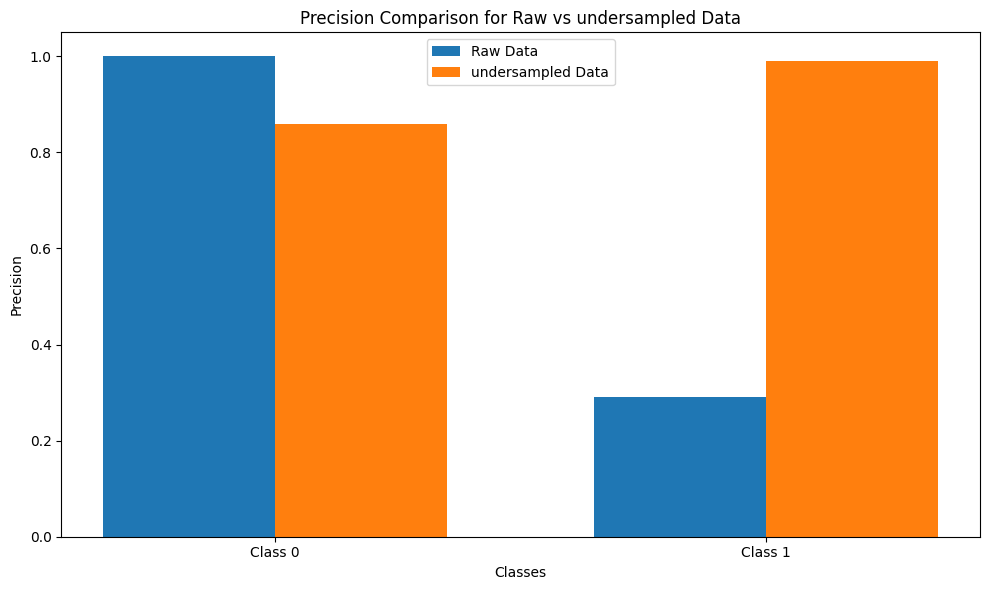

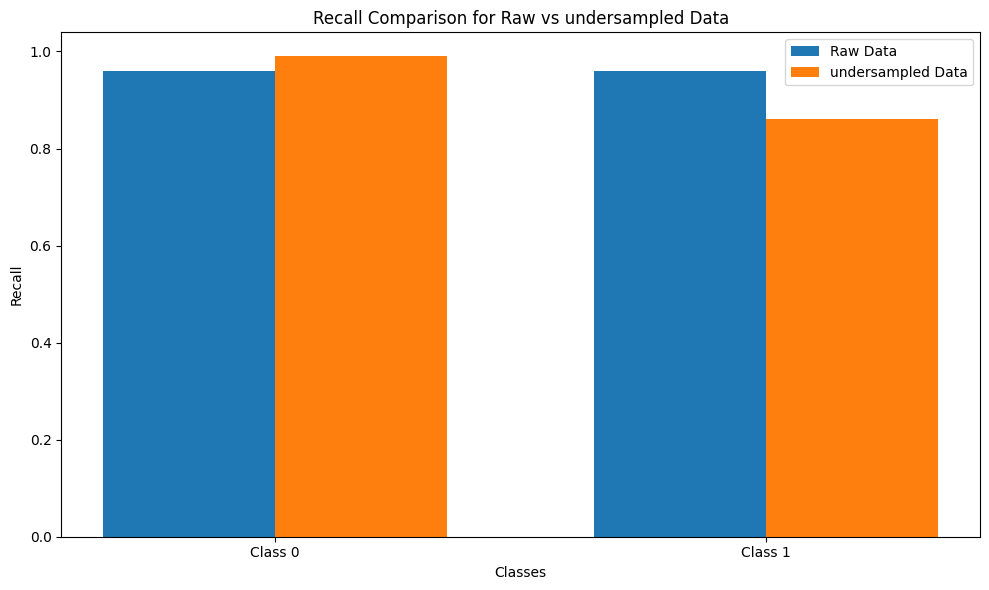

In [ ]:
import matplotlib.pyplot as plt

# Precision and recall values for raw data
raw_precision_0 = 1.00
raw_recall_0 = 0.96
raw_precision_1 = 0.29
raw_recall_1 = 0.96

# Precision and recall values for undersampled data
oversampled_precision_0 = 0.86
oversampled_recall_0 = 0.99
oversampled_precision_1 = 0.99
oversampled_recall_1 = 0.86

# Creating lists for precision and recall values
raw_precision = [raw_precision_0, raw_precision_1]
raw_recall = [raw_recall_0, raw_recall_1]
oversampled_precision = [oversampled_precision_0, oversampled_precision_1]
oversampled_recall = [oversampled_recall_0, oversampled_recall_1]

# Setting up the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = range(2)

# Plotting bars for precision
bar1 = ax.bar(index, raw_precision, bar_width, label='Raw Data')
bar2 = ax.bar([i + bar_width for i in index], oversampled_precision, bar_width, label='undersampled Data')

# Adding labels, title, and legend for precision comparison
ax.set_xlabel('Classes')
ax.set_ylabel('Precision')
ax.set_title('Precision Comparison for Raw vs undersampled Data')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(['Class 0', 'Class 1'])
ax.legend()

# Showing the precision plot
plt.tight_layout()
plt.show()

# Repeating the same process for recall values
fig, ax = plt.subplots(figsize=(10, 6))

bar1 = ax.bar(index, raw_recall, bar_width, label='Raw Data')
bar2 = ax.bar([i + bar_width for i in index], oversampled_recall, bar_width, label='undersampled Data')

ax.set_xlabel('Classes')
ax.set_ylabel('Recall')
ax.set_title('Recall Comparison for Raw vs undersampled Data')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(['Class 0', 'Class 1'])
ax.legend()

plt.tight_layout()
plt.show()


**Summary:**

**Accuracy**: The raw data model achieved the highest accuracy (0.96), followed closely by the oversampling and undersampling models (both 0.92).

**Precision**: The raw data model has perfect precision for Class 0 but low precision for Class 1. Oversampling and undersampling models have more balanced precision for both classes.

**Recall**: The oversampling and undersampling models outperform the raw data model in recall for both classes, indicating their ability to capture more instances of fraud.

**F1-score**: The F1-scores for both classes are generally higher in the oversampling and undersampling models than in the raw data model.

**Conclusion**: The raw data model excels in accuracy and precision for Class 0 but falls short in recall and precision for Class 1.

The oversampling and undersampling models show better balance, with higher recall rates for both classes and more balanced precision.

If equal importance is placed on both classes and higher recall is desired, the oversampling and undersampling models seem preferable despite a slightly lower accuracy compared to the raw data model.

**Challenges faced**

1.  PLM - Took lot of time and space to execute everytime.
2. The data before preprocessing was in HTML format.
3. Faced challenges in naive bayes while combining the features to train the model, related to shape of the dataset.
4. Dataset imbalances - Had to implement different balancing methods.
5. Computationally Expensive for PLMS - Required lot of space to run BERT model.

**Carbon Footprint**
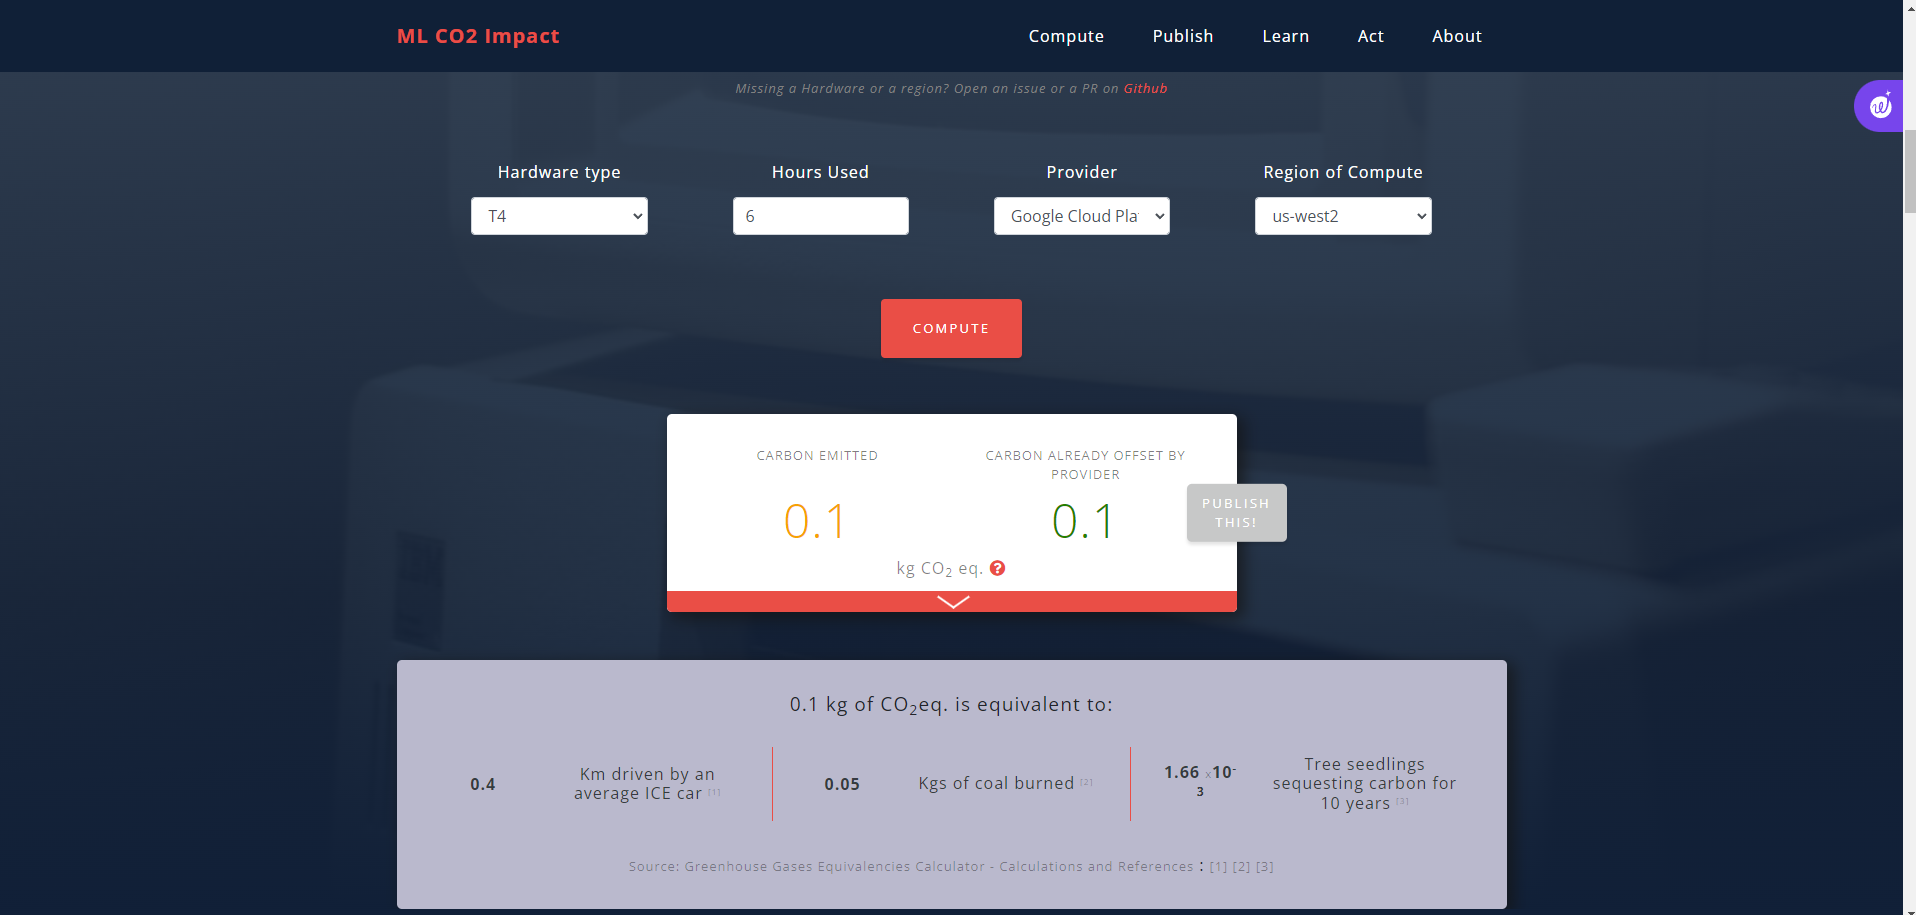